In [2]:
import cv2
import torch
import matplotlib.pyplot as plt
import glob
import random

In [3]:
# Midas
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/nicod/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/nicod/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
imgs = glob.glob("../lidar/data/pyronear_cam_data/**/*.jpg")
len(imgs)

680

In [30]:
# Pick a random image
file = random.choice(imgs)
file

'../pyronear_cam_data/brison_4/pyronear_brison_4_2023_10_14T15_54_43.jpg'

In [59]:
file = '../lidar/data/pyronear_cam_data/brison_1/pyronear_brison_1_2023_08_03T08_42_26.jpg'#brison_4/pyronear_brison_4_2023_07_04T06_07_57.jpg'

In [60]:
# Compute depth using midas
img = cv2.imread(file)[:,:,::-1]
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

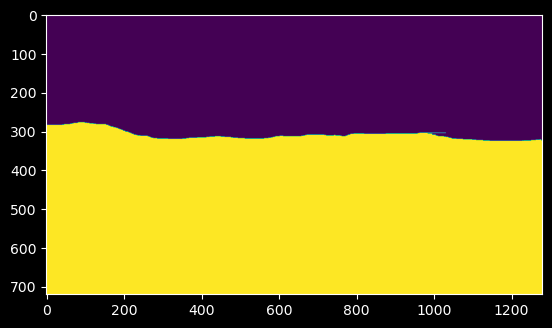

In [61]:
# Threshold depth 
th = 3
(T, res) = cv2.threshold(output, th, 255, cv2.THRESH_BINARY)
plt.imshow(res)

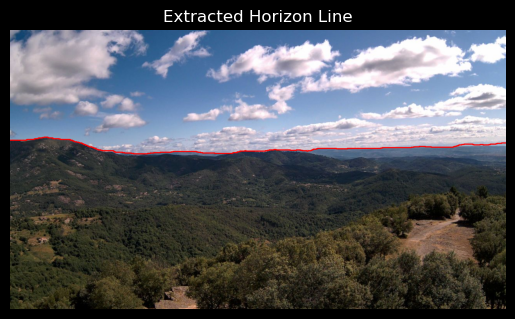

In [49]:
mask_image = res.astype("uint8")

# Threshold the image to make sure it's binary
_, binary_mask = cv2.threshold(mask_image, 127, 255, cv2.THRESH_BINARY)
# extract edges
edges = cv2.Canny(binary_mask, 50, 100) 


# Find contours in the binary mask; the largest contour should correspond to the boundary between the sky and the land
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is the horizon line
# Sort the contours by area and get the largest one
horizon_contour = max(contours, key=cv2.contourArea)


# Draw the horizon contour directly on the color image
img_line = cv2.drawContours(img.astype("uint8"), [horizon_contour], -1, (255, 0, 0), thickness=2)  # Red color for visibility

# Let's display the contour image
plt.imshow(img_line)
plt.title('Extracted Horizon Line')
plt.axis('off')
plt.show()


In [51]:
import numpy as np
# Export contour line
np.save('../lidar/data/horizon/horizon_contour.npy',horizon_contour)